### Import Required Libraries

In [2]:
import string
import re
import numpy as np
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt

KeyboardInterrupt: 

### Read Data

Our data is a text file of English-German sentence pairs. First we will read the file using the function defined below.

In [3]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

Now let's define a function to split the text into English-German pairs separated by '\n' and then split these pairs into English sentences and German sentences.

In [4]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

__Download the data from [here.](http://www.manythings.org/anki/deu-eng.zip)__ and extract "deu.txt" in your working directory.

In [6]:
data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

The actual data contains over 150,000 sentence-pairs. However, we will use the first 50,000 sentence pairs only to reduce the training time of the model. You can change this number as per you system computation power.

In [7]:
deu_eng = deu_eng[:50000,:]

### Text Pre-Processing

#### Text Cleaning

Let's take a look at our data, then we will decide which pre-processing steps to adopt.

In [8]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ["I'm glad you're glad.", 'Ich freue mich, dass Sie sich freuen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3396771 (CK) & #3405621 (Pfirsichbaeumchen)'],
       ["I'm glad you're here.", 'Ich bin froh, dass du hier bist.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1890982 (CK) & #782823 (Chris)'],
       ["I'm glad you're here.", 'Ich bin froh, dass ihr hier seid.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1890982 (CK) & #8483032 (Luiaard)']],
      dtype='<U537')

We will get rid of the punctuation marks, and then convert the text to lower case.

In [9]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [10]:
deu_eng

array([['Go', 'Geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi', 'Hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi', 'Grüß Gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['Im glad youre glad', 'Ich freue mich dass Sie sich freuen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3396771 (CK) & #3405621 (Pfirsichbaeumchen)'],
       ['Im glad youre here', 'Ich bin froh dass du hier bist',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1890982 (CK) & #782823 (Chris)'],
       ['Im glad youre here', 'Ich bin froh dass ihr hier seid',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1890982 (CK) & #8483032 (Luiaard)']],
      dtype='<U537')

In [11]:
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    
    deu_eng[i,1] = deu_eng[i,1].lower()

In [12]:
deu_eng

array([['go', 'geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['hi', 'hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['hi', 'grüß gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['im glad youre glad', 'ich freue mich dass sie sich freuen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3396771 (CK) & #3405621 (Pfirsichbaeumchen)'],
       ['im glad youre here', 'ich bin froh dass du hier bist',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1890982 (CK) & #782823 (Chris)'],
       ['im glad youre here', 'ich bin froh dass ihr hier seid',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1890982 (CK) & #8483032 (Luiaard)']],
      dtype='<U537')

#### Text to Sequence Conversion

To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and German, respectively.

In [13]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

In [14]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

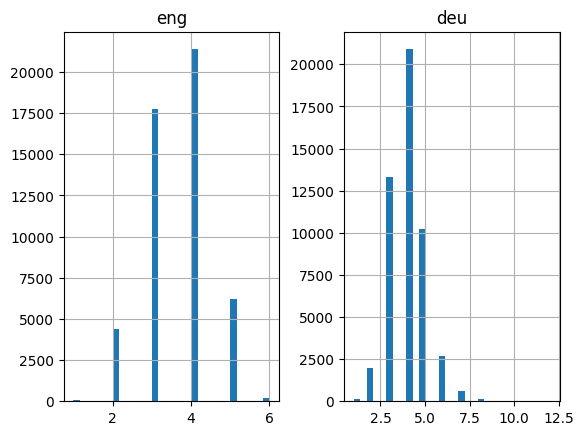

In [15]:
length_df.hist(bins = 30)
plt.show()

The maximum length of the German sentences is 11 and that of the English phrases is 8.

Let's vectorize our text data by using Keras's Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

In [16]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [17]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6084


In [18]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10077


Given below is a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above. 

In [19]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

### Model Building

We will now split the data into train and test set for model training and evaluation, respectively.

In [20]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

It's time to encode the sentences. We will encode German sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

In [21]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [22]:
# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

Now comes the exciting part! Let us define our Seq2Seq model architecture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.  

In [24]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()

    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))

    return model

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

In [25]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

2023-12-10 21:42:19.661077: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-10 21:42:19.661364: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Please note that we have used __'sparse_categorical_crossentropy'__ as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

It seems we are all set to start training our model. We will train it for 30 epochs and with a batch size of 512. You may change and play these hyperparameters. We will also be using __ModelCheckpoint()__ to save the best model with lowest validation loss. I personally prefer this method over early stopping.

In [26]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/30


63/63 [==============================] - ETA: 0s - loss: 4.2201
Epoch 1: val_loss improved from inf to 3.07105, saving model to model.h1.24_jan_19
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 43s 642ms/step - loss: 4.2201 - val_loss: 3.0710
Epoch 2/30
63/63 [==============================] - ETA: 0s - loss: 2.8779
Epoch 2: val_loss improved from 3.07105 to 2.82160, saving model to model.h1.24_jan_19
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 40s 630ms/step - loss: 2.8779 - val_loss: 2.8216
Epoch 3/30
63/63 [==============================] - ETA: 0s - loss: 2.7357
Epoch 3: val_loss improved from 2.82160 to 2.71399, saving model to model.h1.24_jan_19
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 40s 637ms/step - loss: 2.7357 - val_loss: 2.7140
Epoch 4/30
63/63 [==============================] - ETA: 0s - loss: 2.6903
Epoch 4: val_loss improved from 2.71399 to 2.68990, saving model to model.h1.24_jan_19
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 40s 633ms/step - loss: 2.6903 - val_loss: 2.6899
Epoch 5/30
63/63 [==============================] - ETA: 0s - loss: 2.6639
Epoch 5: val_loss improved from 2.68990 to 2.67601, saving model to model.h1.24_jan_19
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 40s 641ms/step - loss: 2.6639 - val_loss: 2.6760
Epoch 6/30
63/63 [==============================] - ETA: 0s - loss: 2.6438
Epoch 6: val_loss improved from 2.67601 to 2.65596, saving model to model.h1.24_jan_19
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 39s 625ms/step - loss: 2.6438 - val_loss: 2.6560
Epoch 7/30
63/63 [==============================] - ETA: 0s - loss: 2.6250
Epoch 7: val_loss improved from 2.65596 to 2.64282, saving model to model.h1.24_jan_19
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 40s 637ms/step - loss: 2.6250 - val_loss: 2.6428
Epoch 8/30
63/63 [==============================] - ETA: 0s - loss: 2.6102
Epoch 8: val_loss improved from 2.64282 to 2.62566, saving model to model.h1.24_jan_19
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 40s 631ms/step - loss: 2.6102 - val_loss: 2.6257
Epoch 9/30
63/63 [==============================] - ETA: 0s - loss: 2.5862
Epoch 9: val_loss improved from 2.62566 to 2.60447, saving model to model.h1.24_jan_19
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 39s 624ms/step - loss: 2.5862 - val_loss: 2.6045
Epoch 10/30
63/63 [==============================] - ETA: 0s - loss: 2.5579
Epoch 10: val_loss improved from 2.60447 to 2.58027, saving model to model.h1.24_jan_19
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 40s 636ms/step - loss: 2.5579 - val_loss: 2.5803
Epoch 11/30
63/63 [==============================] - ETA: 0s - loss: 2.5390
Epoch 11: val_loss improved from 2.58027 to 2.55555, saving model to model.h1.24_jan_19
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 39s 618ms/step - loss: 2.5390 - val_loss: 2.5556
Epoch 12/30
63/63 [==============================] - ETA: 0s - loss: 2.5155
Epoch 12: val_loss improved from 2.55555 to 2.54410, saving model to model.h1.24_jan_19
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 41s 657ms/step - loss: 2.5155 - val_loss: 2.5441
Epoch 13/30
63/63 [==============================] - ETA: 0s - loss: 2.4901
Epoch 13: val_loss improved from 2.54410 to 2.52145, saving model to model.h1.24_jan_19
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 39s 624ms/step - loss: 2.4901 - val_loss: 2.5215
Epoch 14/30
63/63 [==============================] - ETA: 0s - loss: 2.4693
Epoch 14: val_loss improved from 2.52145 to 2.50089, saving model to model.h1.24_jan_19
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 40s 633ms/step - loss: 2.4693 - val_loss: 2.5009
Epoch 15/30
63/63 [==============================] - ETA: 0s - loss: 2.4517
Epoch 15: val_loss improved from 2.50089 to 2.48246, saving model to model.h1.24_jan_19
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 39s 623ms/step - loss: 2.4517 - val_loss: 2.4825
Epoch 16/30
63/63 [==============================] - ETA: 0s - loss: 2.4337
Epoch 16: val_loss improved from 2.48246 to 2.46826, saving model to model.h1.24_jan_19
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 40s 639ms/step - loss: 2.4337 - val_loss: 2.4683
Epoch 17/30
63/63 [==============================] - ETA: 0s - loss: 2.4138
Epoch 17: val_loss improved from 2.46826 to 2.45460, saving model to model.h1.24_jan_19
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 39s 625ms/step - loss: 2.4138 - val_loss: 2.4546
Epoch 18/30
63/63 [==============================] - ETA: 0s - loss: 2.3965
Epoch 18: val_loss improved from 2.45460 to 2.43091, saving model to model.h1.24_jan_19
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 41s 654ms/step - loss: 2.3965 - val_loss: 2.4309
Epoch 19/30
63/63 [==============================] - ETA: 0s - loss: 2.3750
Epoch 19: val_loss improved from 2.43091 to 2.42509, saving model to model.h1.24_jan_19
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 40s 641ms/step - loss: 2.3750 - val_loss: 2.4251
Epoch 20/30
63/63 [==============================] - ETA: 0s - loss: 2.3508
Epoch 20: val_loss improved from 2.42509 to 2.39046, saving model to model.h1.24_jan_19
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 39s 624ms/step - loss: 2.3508 - val_loss: 2.3905
Epoch 21/30
63/63 [==============================] - ETA: 0s - loss: 2.3266
Epoch 21: val_loss improved from 2.39046 to 2.36089, saving model to model.h1.24_jan_19
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 38s 612ms/step - loss: 2.3266 - val_loss: 2.3609
Epoch 22/30
63/63 [==============================] - ETA: 0s - loss: 2.3045
Epoch 22: val_loss improved from 2.36089 to 2.35761, saving model to model.h1.24_jan_19
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 39s 625ms/step - loss: 2.3045 - val_loss: 2.3576
Epoch 23/30
63/63 [==============================] - ETA: 0s - loss: 2.2832
Epoch 23: val_loss improved from 2.35761 to 2.33133, saving model to model.h1.24_jan_19
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 39s 625ms/step - loss: 2.2832 - val_loss: 2.3313
Epoch 24/30
63/63 [==============================] - ETA: 0s - loss: 2.2620
Epoch 24: val_loss improved from 2.33133 to 2.31306, saving model to model.h1.24_jan_19
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 39s 613ms/step - loss: 2.2620 - val_loss: 2.3131
Epoch 25/30
63/63 [==============================] - ETA: 0s - loss: 2.2411
Epoch 25: val_loss improved from 2.31306 to 2.29430, saving model to model.h1.24_jan_19
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 39s 622ms/step - loss: 2.2411 - val_loss: 2.2943
Epoch 26/30
63/63 [==============================] - ETA: 0s - loss: 2.2216
Epoch 26: val_loss improved from 2.29430 to 2.27853, saving model to model.h1.24_jan_19
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 38s 609ms/step - loss: 2.2216 - val_loss: 2.2785
Epoch 27/30
63/63 [==============================] - ETA: 0s - loss: 2.2029
Epoch 27: val_loss improved from 2.27853 to 2.26405, saving model to model.h1.24_jan_19
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 39s 625ms/step - loss: 2.2029 - val_loss: 2.2641
Epoch 28/30
63/63 [==============================] - ETA: 0s - loss: 2.1807
Epoch 28: val_loss improved from 2.26405 to 2.24405, saving model to model.h1.24_jan_19
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 39s 628ms/step - loss: 2.1807 - val_loss: 2.2440
Epoch 29/30
63/63 [==============================] - ETA: 0s - loss: 2.1612
Epoch 29: val_loss improved from 2.24405 to 2.23721, saving model to model.h1.24_jan_19
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 40s 631ms/step - loss: 2.1612 - val_loss: 2.2372
Epoch 30/30
63/63 [==============================] - ETA: 0s - loss: 2.1401
Epoch 30: val_loss improved from 2.23721 to 2.23154, saving model to model.h1.24_jan_19
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


63/63 [==============================] - 40s 630ms/step - loss: 2.1401 - val_loss: 2.2315


Let's compare the training loss and the validation loss.

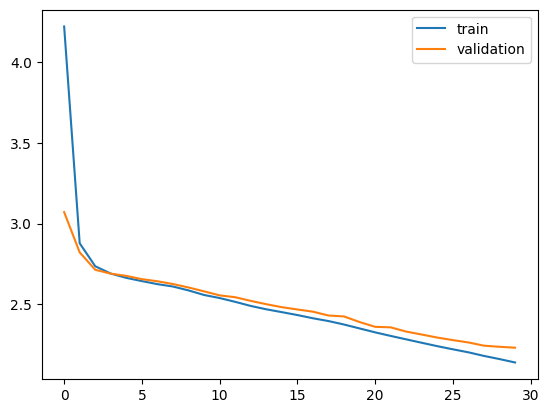

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Make Predictions

Let's load the saved model to make predictions.

In [29]:
model = load_model('model.h1.24_jan_19')
preds = model.predict(testX.reshape((testX.shape[0],testX.shape[1])))
preds_classes = np.argmax(preds, axis=-1)

2023-12-10 22:03:47.438026: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-10 22:03:47.494090: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-10 22:03:47.501587: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-10 22:03:47.510404: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2023-12-10 22:03:47.517317: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 5 outputs but the _output_sh

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [ ]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [ ]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [ ]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [ ]:
pd.set_option('display.max_colwidth', 200)

In [ ]:
pred_df.head(15)

,actual,predicted
0,weve run out of gas,we have out of gas
1,its a fad,this is a
2,tom was shaken,tom was distressed
3,this annoys me,this me
4,let me do that for you,let me do you
5,you will pay for this,youll pay for this
6,tom often cuts classes,tom often to
7,hes young and healthy,he is young angry
8,life is enjoyable,life is beautiful
9,i know it sounds silly,i know it


In [ ]:
pred_df.tail(15)

,actual,predicted
9985,tom knew the risks,tom was all of
9986,what does she do,what does you do
9987,she still loved him,she still him sing
9988,i want to be careful,i want to be boston
9989,im here arent i,im here
9990,youre a hypocrite,youre a hypocrite
9991,i gave you a book,i gave you a book
9992,lets do it,do it
9993,i broke my leg skiing,i broke my
9994,i was victorious,i was been asleep


In [ ]:
pred_df.tail(15)

,actual,predicted
9985,tom knew the risks,tom was all of
9986,what does she do,what does you do
9987,she still loved him,she still him sing
9988,i want to be careful,i want to be boston
9989,im here arent i,im here
9990,youre a hypocrite,youre a hypocrite
9991,i gave you a book,i gave you a book
9992,lets do it,do it
9993,i broke my leg skiing,i broke my
9994,i was victorious,i was been asleep


In [ ]:
pred_df.sample(15)

,actual,predicted
4719,id like to know why,id like to know why
6533,i dont need a car,i dont need a car
8505,youve got a fever,you have a fever
6081,dont come again,dont come again
5615,im tired of boston,im am boston
868,i mean no disrespect,i dont want to be
1415,take a number,take a number
3561,what does it say,what does it
1292,shes still young,she is young
7759,youre out of order,youre not normal
